In [2]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 0 # 3142

import numpy as np

np.random.seed(algorithm_globals.random_seed)

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size = 20, 
                test_size = 5, 
                n = 2,
                gap = 0.3, 
                one_hot = False)
)

In [4]:
print (TRAIN_DATA.size)

80


In [5]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension = 2, reps = 2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps = 2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐ ░ »
«   q_0: ┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├┤ Rz(θ[10]) ├─░─»
«        ├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤├───────────┤ ░ »
«   q_1: ┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─»
«        └──────────┘   └──────────┘└──────────┘   └──────────┘└───────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌─┐   
«   q_0: ┤M├───
«        └╥┘┌─┐
«   q_1: ─╫─┤M├
«         ║ └╥┘
«meas: 2/═╩══╩═
«         0  1

In [6]:
def circuit_instance(data, variational):
    """Assigns parameter values to AD_HOC_CIRCUIT. 
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for VAR_FORM
    Returns:
        QuantumCircuit: AD_HOC_CIRCUIT with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [7]:
def parity(bitstring):
    """Returns 1 if parity of 'bitstring' is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1)%2


In [8]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [9]:
from qiskit import BasicAer, execute, Aer
from qiskit_aer import aer_simulator

def classification_probability(data, variational):
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('aer_simulator')
    results = execute(circuits, backend).result()
    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [10]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    #print (cost)
    return cost

In [11]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

initial_point = np.random.random(VAR_FORM.num_parameters)
#initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
#                          0.88372228, 4.08885928, 2.45568528,
#                          4.92364593, 5.59032015, 3.66837805,
#                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

In [11]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

from time import time
tic = time()
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)
toc = time()
print ("time:", toc-tic)

opt_var = result.x
opt_value = result.fun

time: 237.0409836769104


In [14]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log_momentum = OptimizerLog()

from optimizers.momentumSPSA import SPSAMomentum
optimizer = SPSAMomentum(maxiter=100, callback=log_momentum.update)

from time import time
tic = time()
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)
toc = time()
print ("time:", toc-tic)

opt_var = result.x
opt_value = result.fun

KeyboardInterrupt: 

In [14]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log_momentum2 = OptimizerLog()

def powerseries(eta=0.01, power=2, offset=0):
    """Yield a series decreasing by a powerlaw."""

    n = 1
    while True:
        yield eta / ((n + offset) ** power)
        n += 1

def perturbation(): # the default perturbation
    return powerseries(0.2, 0.101) 

optimizer = SPSAMomentum(maxiter=100, callback=log_momentum2.update, 
                         learning_rate = 0.1, perturbation = perturbation)
# optimizer = SPSA(maxiter=100, callback=log.update)
#optimizer = SPSA(maxiter=50, callback=log.update, second_order = True)

from time import time
tic = time()
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)
toc = time()
print ("time:", toc-tic)

opt_var = result.x
opt_value = result.fun

print ("opt_value", opt_value)
print (opt_var, opt_var)

time: 220.27624011039734
opt_value 0.27064639917000644
[1.07119338 1.45146245 1.09578495 0.13457796 1.19488721 0.63260797
 0.27711945 0.72963419 1.50027462 0.38280823 0.56426235 0.22834807] [1.07119338 1.45146245 1.09578495 0.13457796 1.19488721 0.63260797
 0.27711945 0.72963419 1.50027462 0.38280823 0.56426235 0.22834807]


In [15]:
log_adam = OptimizerLog()

from optimizers.momentumSPSA import SPSAMomentum
optimizer = SPSAAdam(maxiter=100, callback=log_adam.update)

from time import time
tic = time()
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)
toc = time()
print ("time:", toc-tic)

opt_var = result.x
opt_value = result.fun

print ("opt_value", opt_value)
print ("opt_var", opt_var)

time: 255.11514925956726
opt_value 0.25322561952047
opt_var [-0.04591805  1.73181813 -0.29090224  1.48723732  1.76199892 -0.13920492
  0.63022368  0.45109264  2.77953591  0.49973754  1.04641503  2.40861995]


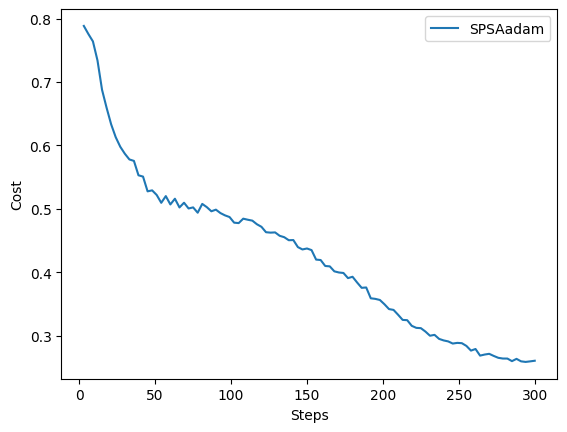

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(log.evaluations, log.costs, label = "spsa") #baseline
#plt.plot(log_momentum.evaluations, log_momentum.costs, label = "SPSAmomentum") #momentum
#plt.plot(log_momentum2.evaluations, log_momentum2.costs, 
#         label = "SPSAmomentum constant learning rate") #constant learning rate
plt.plot(log_adam.evaluations, log_adam.costs, label = "SPSAadam") #adam
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [19]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

0.9

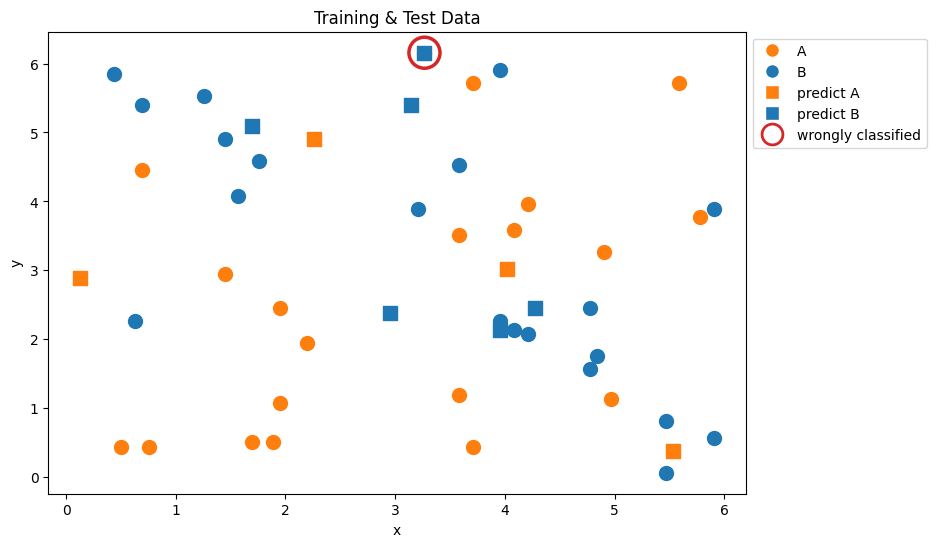

In [20]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [21]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

In [31]:
from qiskit_machine_learning.algorithms.classifiers import VQC
log_vqc_mom = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSAMomentum(callback=log_vqc_mom.update),
          initial_point=initial_point
          #quantum_instance=Aer.get_backend('aer_simulator')
         )
tic = time()
vqc.fit(TRAIN_DATA, train_labels_oh)
toc = time()
print ("time:", toc - tic)

time: 45.7890682220459


In [35]:
from qiskit_machine_learning.algorithms.classifiers import VQC
log_vqc_adam = OptimizerLog()
vqc_adam = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSAMomentum(callback=log_vqc_adam.update),
          initial_point=initial_point
          #quantum_instance=Aer.get_backend('aer_simulator')
         )
tic = time()
vqc_adam.fit(TRAIN_DATA, train_labels_oh)
toc = time()
print ("time:", toc - tic)

time: 44.735801696777344


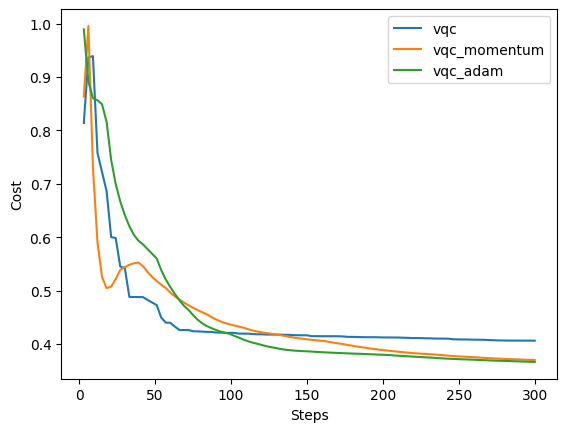

In [37]:
fig = plt.figure()
plt.plot(log_vqc.evaluations, log_vqc.costs, label = "vqc")
plt.plot(log_vqc_mom.evaluations, log_vqc_mom.costs, label = "vqc_momentum")
plt.plot(log_vqc_adam.evaluations, log_vqc_adam.costs, label = "vqc_adam")
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [38]:
# score == accuracy
vqc_adam.score(TEST_DATA, test_labels_oh)

1.0

## conlusion

Adam does not show improvement over SPSA

1. Momentum only work on (batch) SGD
2. The SPSA has more hyperparameter tuning

    a. decay perturbation size and learning rate
    
    b. Clipping, trust-region, o